In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import scipy.stats
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("Wimbledon_featured_matches.csv")

df.insert(4, "elapsed_time_seconds", pd.to_timedelta(df['elapsed_time']).dt.total_seconds())

df.insert(5, 'point_time', df.groupby('match_id')['elapsed_time_seconds'].diff())

df['point_time'].fillna(0, inplace=True)

error_ids = [391, 584, 756, 1171, 1347, 1479, 1569, 1685, 1851, 2349, 3985, 4381]

df.loc[df.index.isin(error_ids), 'point_time'] = np.nan

df.insert(5, 'point_time_na', df["point_time"])

mean_point_time_per_match = df.groupby('match_id')['point_time'].transform('mean')
df['point_time'] = df['point_time'].fillna(mean_point_time_per_match)

df['point_differential'] = df['p1_points_won'] - df['p2_points_won']

df.insert(1, "match_id_int", pd.to_numeric(df['match_id'].str.extract('(\d{4})$', expand=False), errors='coerce'))

lastrows = df.groupby('match_id').last()
column_indices = [lastrows.columns.get_loc(col) for col in ['p1_sets','p2_sets','set_victor', 'point_differential']]

result = lastrows.iloc[:, column_indices]

lastrows['winners'] = result['set_victor']

df = pd.merge(df, lastrows[['match_id_int', 'winners']], on='match_id', how='left')
df.drop("match_id_int_y", axis=1, inplace=True)
df.rename(columns={'match_id_int_x': 'match_id_int'}, inplace=True)

df['player1_streak'] = 0
df['player2_streak'] = 0

player1_streak_counter = 0
player2_streak_counter = 0
match_id = None

for index, row in df.iterrows():
    if (match_id == row['match_id_int']): 
        if row['point_victor'] == 1:
            player1_streak_counter += 1
            player2_streak_counter = 0 
        else:
            player2_streak_counter += 1
            player1_streak_counter = 0 
        
        df.at[index, 'player1_streak'] = player1_streak_counter
        df.at[index, 'player2_streak'] = player2_streak_counter
    else:
        match_id = row['match_id_int']
        if row['point_victor'] == 1:
            player1_streak_counter = 1
            player2_streak_counter = 0  
        else:
            player2_streak_counter = 1
            player1_streak_counter = 0  
    
        df.at[index, 'player1_streak'] = player1_streak_counter
        df.at[index, 'player2_streak'] = player2_streak_counter

df['streak_differential'] = df['player1_streak'] - df['player2_streak']

df['ace_diff'] = df['p1_ace'] - df['p2_ace']
df['win_untouchshot_diff'] = df['p1_winner'] - df['p2_winner']
df['double_fault_diff'] = df['p1_double_fault'] - df['p2_double_fault']
df['net_pt_won_diff'] = df['p1_net_pt_won'] - df['p2_net_pt_won']
df['point_break_diff'] = df['p1_break_pt_won'] - df['p2_break_pt_won']
df['unf_err'] = df['p1_unf_err'] - df['p2_unf_err']

def calcEMA(values, win):
    arr = []
    for i in range(0, win-1):
        arr.append(np.average(values[0:i+1]))
    for i in range(win-1, len(values)):
        if i == win-1:
            arr.append(np.average(values[0:win+1]))
        else:
            small_avg = arr[len(arr)-1] 
            ema_calc = (values[i] - small_avg) * (2/(win+1)) + small_avg
            arr.append(ema_calc)
    return arr

all_ema_small = []
all_ema_big = []
all_momentum = []


for match_id in df['match_id'].unique():
    game = df[df['match_id'] == match_id]

    ema_small = calcEMA(np.array(game['point_differential']), 12)
    ema_big = calcEMA(np.array(game['point_differential']), 26)
    momentum = np.subtract(ema_small, ema_big)

    all_ema_small.extend(ema_small)
    all_ema_big.extend(ema_big)
    all_momentum.extend(momentum)

df['ema_small'] = all_ema_small
df['ema_big'] = all_ema_big
df['momentum'] = all_momentum

## Point Differential Plot
Plots the point differential between player1 and player2 throughout the entire match. 

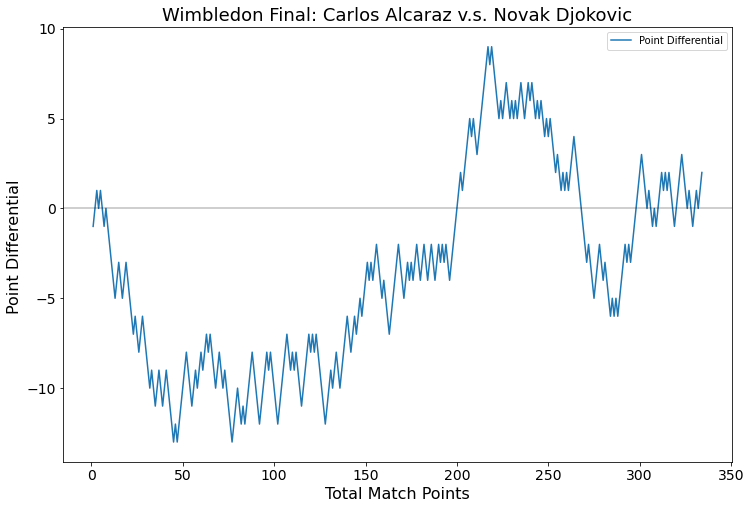

In [3]:
def point_differential_plot(name):
    game = df[df['match_id_int'] == name]
    winner = game['winners'].values[0]
    
    plt.figure(figsize=(12,8))
    plt.plot(game['point_no'], game['point_differential'], label='Point Differential')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.25)  # Add a dashed line at y=0 for reference
    
    plt.xlabel('Total Match Points', fontsize = 16)
    plt.ylabel('Point Differential ', fontsize = 16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(f'Wimbledon Final: Carlos Alcaraz v.s. Novak Djokovic', fontsize = 18)
    
    # Add legend
    plt.legend()

    plt.show()

def allgames():
    for name in df['match_id_int'].unique():
        point_differential_plot(name)


point_differential_plot(1701)

#Uncomment below if you want to print every games point differential over the course of the match.
#allgames() 


## Correlation Test between winners of match and point differential

In [4]:
pearson_corr, pearson_p_value = scipy.stats.pearsonr(lastrows["winners"], lastrows["point_differential"])

spearman_corr, spearman_p_value = scipy.stats.spearmanr(lastrows["winners"], lastrows["point_differential"])

print(f"Pearson Correlation: {pearson_corr}")
print(f"Pearson p-value: {pearson_p_value}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Spearman p-value: {spearman_p_value}")

Pearson Correlation: -0.841283619181918
Pearson p-value: 3.088198863749006e-09
Spearman Correlation: -0.7921863232742419
Spearman p-value: 1.0978132254709838e-07


## MACD Model Implementation

The following code will implement the moving average convergence divergence model by taking two moving averages at different window sizes and taking the difference of them. The plot contains: Point differential against points with indicators for winners of sets and games. Plot of the moving averages and the difference (this is our momentum).

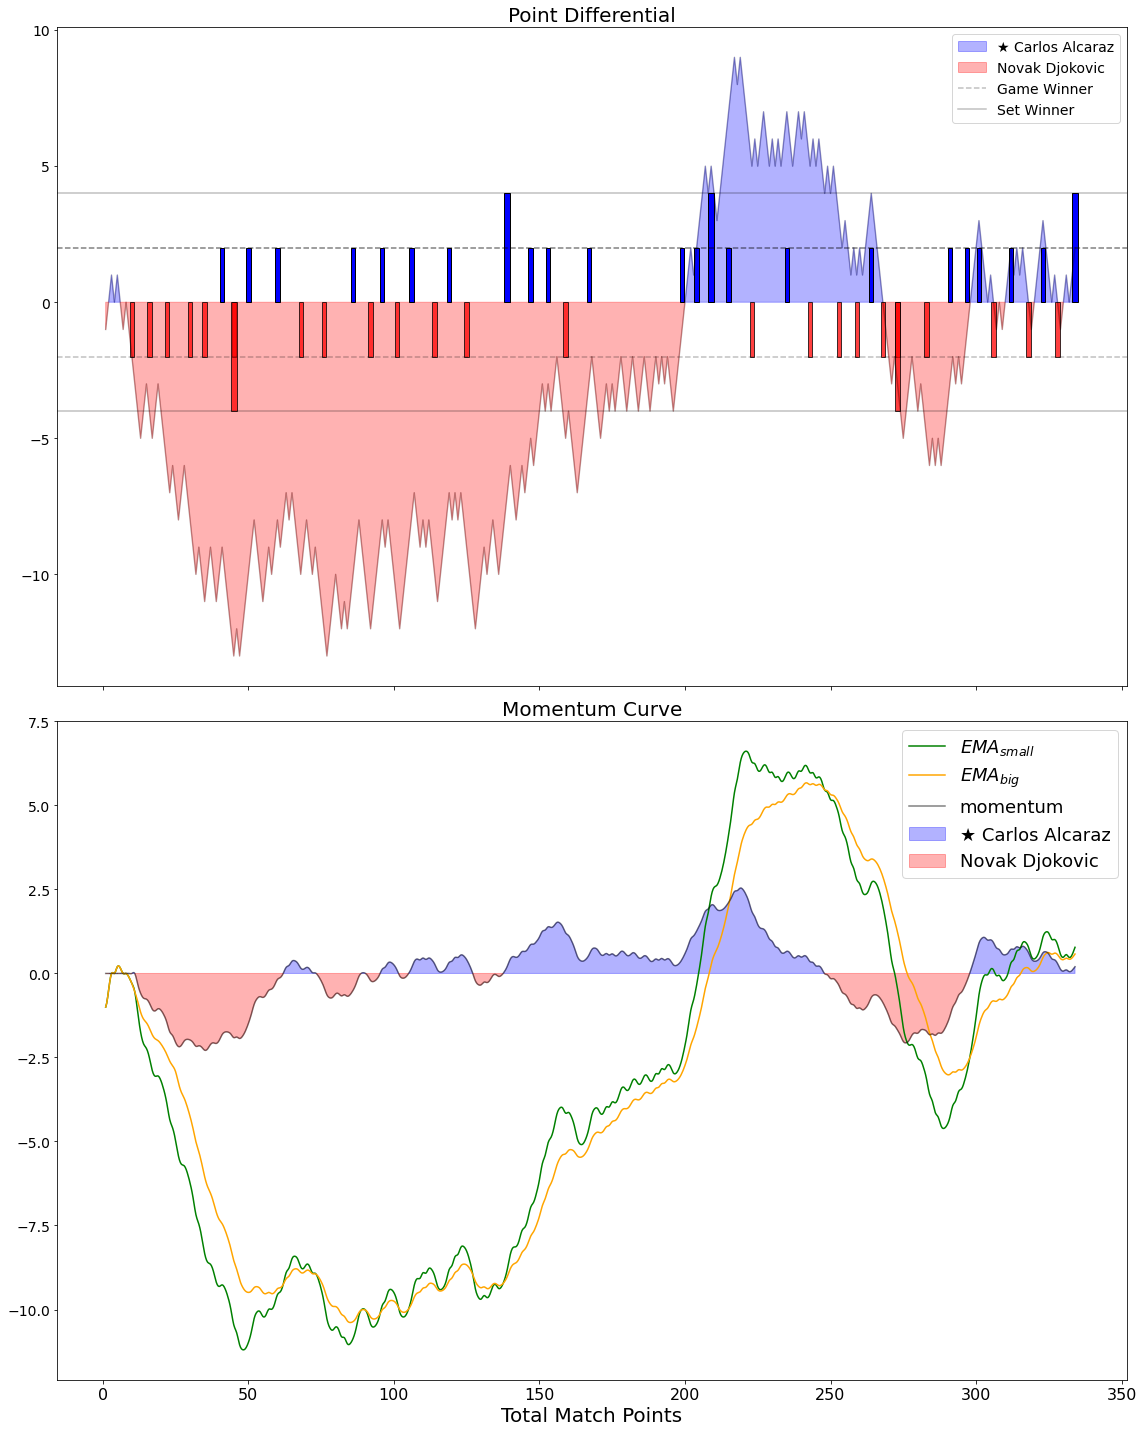

In [6]:
def MCAD(target, points, fwin, swin, winner, player_1, player_2):
    values = np.array(target)
    small_ema = calcEMA(values, fwin)
    large_ema = calcEMA(values, swin)
    macd = np.subtract(small_ema, large_ema)

    small_ema = smoothing(points,small_ema,3)
    large_ema = smoothing(points,large_ema,3)
    values = smoothing(points, values, 1)
    macd = smoothing(points, macd, 3)

    points = np.linspace(points.min(), points.max(), 1000)

    if(winner == 1):
        player_1 = "★ " + player_1
    else:
        player_2 = "★ " + player_2
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20), sharex=True)

    last_instance_indices = game.groupby(['set_no', 'game_no'])['point_no'].idxmax()
    last_instance_points = game.loc[last_instance_indices, ['set_no', 'game_no', 'point_no', 'point_differential', 'point_victor']]

    last_set_indices = game.groupby('set_no')['point_no'].idxmax()
    last_set_points = game.loc[last_set_indices, ['set_no', 'game_no', 'point_no', 'point_differential', 'point_victor']]

    ax1.plot(points, values, color='black', alpha=0.25)
    ax1.fill_between(points, values, color='blue', where=(values > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax1.fill_between(points, values, color='red', where=(values < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    winner_points_1 = last_instance_points[last_instance_points['point_victor'] == 1]
    ax1.bar(winner_points_1['point_no'], 2, width=1.5, color='blue',edgecolor='black')

    winner_points_2 = last_instance_points[last_instance_points['point_victor'] == 2]
    ax1.bar(winner_points_2['point_no'], -2, width=1.5, color='red',edgecolor='black',  alpha = 0.75)

    winner_set_points_1 = last_set_points[last_set_points['point_victor'] == 1]
    ax1.bar(winner_set_points_1['point_no'], 4, width=2, color='blue',edgecolor='black')

    winner_set_points_2 = last_set_points[last_set_points['point_victor'] == 2]
    ax1.bar(winner_set_points_2['point_no'], -4, width=2, color='red', edgecolor='black', alpha = 0.75)

    ax1.axhline(y=2, color='black', linestyle='--', alpha=0.5)
    ax1.axhline(y=-2, color='black', linestyle='--', alpha=0.25, label='Game Winner')
    ax1.axhline(y=4, color='black', linestyle='-', alpha=0.25)
    ax1.axhline(y=-4, color='black', linestyle='-', alpha=0.25, label='Set Winner')
    ax1.legend(fontsize=14)
    ax1.set_title('Point Differential', fontsize=20)
    ax1.tick_params(axis='y', labelsize=14)

    ax2.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax2.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax2.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax2.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax2.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax2.legend(fontsize=18)
    ax2.set_title('Momentum Curve', fontsize=20)

    plt.xlabel('Total Match Points', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


def calcEMA(values, win):
    arr = []
    for i in range(0, win-1):
        arr.append(np.average(values[0:i+1]))
    for i in range(win-1, len(values)):
        if i == win-1:
            arr.append(np.average(values[0:win+1]))
        else:
            small_avg = arr[len(arr)-1] 
            ema_calc = (values[i] - small_avg) * (2/(win+1)) + small_avg
            arr.append(ema_calc)
    return arr

def smoothing(x, y, k):
    spl = make_interp_spline(x, y, k=k)
    x_smooth = np.linspace(x.min(), x.max(), 1000)
    y_smooth = spl(x_smooth)
    return  y_smooth


def allGames():
    for name in df['match_id'].unique():
        game = df[df['match_id'] == name]
        MCAD(game['point_differential'], game['point_no'], 12, 26, game['winners'].max(), game['player1'].min(), game['player2'].min())
# call allGames if you want to print the momentum curve for each game.

#Important games IDs: 1701 and 1304

game = df[df['match_id_int'] == 1701]
MCAD(game['point_differential'], game['point_no'], 12, 26, game['winners'].max(), game['player1'].min(), game['player2'].min())

## Correlation Tests to determine if certain event have impact on momentum

In [23]:
game = df[df["match_id_int"] == 1701]

def calcEMA(values, win):
    arr = []
    for i in range(0, win-1):
        arr.append(np.average(values[0:i+1]))
    for i in range(win-1, len(values)):
        if i == win-1:
            arr.append(np.average(values[0:win+1]))
        else:
            small_avg = arr[len(arr)-1] 
            ema_calc = (values[i] - small_avg) * (2/(win+1)) + small_avg
            arr.append(ema_calc)
    return arr

confidences_variables = ['ace_diff', 'win_untouchshot_diff', 'double_fault_diff', 'net_pt_won_diff', 'point_break_diff', 'unf_err']
player1_conf =  ['p1_ace', 'p1_winner', 'p1_double_fault', 'p1_unf_err', 'p1_net_pt_won', 'p1_break_pt_won', 'p1_unf_err']
player2_conf = ['p2_ace', 'p2_winner', 'p2_double_fault',  'p2_unf_err', 'p2_net_pt_won', 'p2_break_pt_won', 'p2_unf_err']
       
ema_small = calcEMA(np.array(game['point_differential']), 12)
ema_big = calcEMA(np.array(game['point_differential']), 26)
momentum = np.subtract(ema_small, ema_big)

game['ema_small'] = ema_small
game['ema_big'] = ema_big
game['momentum'] = momentum

for variables in [confidences_variables, player1_conf, player2_conf]:

    correlation_matrix_column1, p_values = [], []

    for var in variables:
        corr, p_value = pearsonr(game[var], game['momentum'])
        correlation_matrix_column1.append(corr)
        p_values.append(p_value)

    # Create a DataFrame with correlation coefficients and p-values
    result_df = pd.DataFrame({'Correlation': correlation_matrix_column1, 'P-Value': p_values}, variables)
    print("Correlation and P-Value DataFrame:")
    print(result_df)
    

Correlation and P-Value DataFrame:
                      Correlation   P-Value
ace_diff                 0.068726  0.210281
win_untouchshot_diff    -0.020114  0.714180
double_fault_diff       -0.012893  0.814397
net_pt_won_diff         -0.008736  0.873616
point_break_diff         0.126614  0.020635
unf_err                 -0.118128  0.030902
Correlation and P-Value DataFrame:
                 Correlation   P-Value
p1_ace              0.059829  0.275581
p1_winner          -0.042769  0.435947
p1_double_fault    -0.017436  0.750875
p1_unf_err         -0.077918  0.155370
p1_net_pt_won      -0.024614  0.653992
p1_break_pt_won     0.070402  0.199346
p1_unf_err         -0.077918  0.155370
Correlation and P-Value DataFrame:
                 Correlation   P-Value
p2_ace             -0.035008  0.523736
p2_winner          -0.021504  0.695372
p2_double_fault    -0.002883  0.958133
p2_unf_err          0.101521  0.063854
p2_net_pt_won      -0.009303  0.865499
p2_break_pt_won    -0.110012  0.044525
p2

## Momentum Curve with confidence effecting events labelled

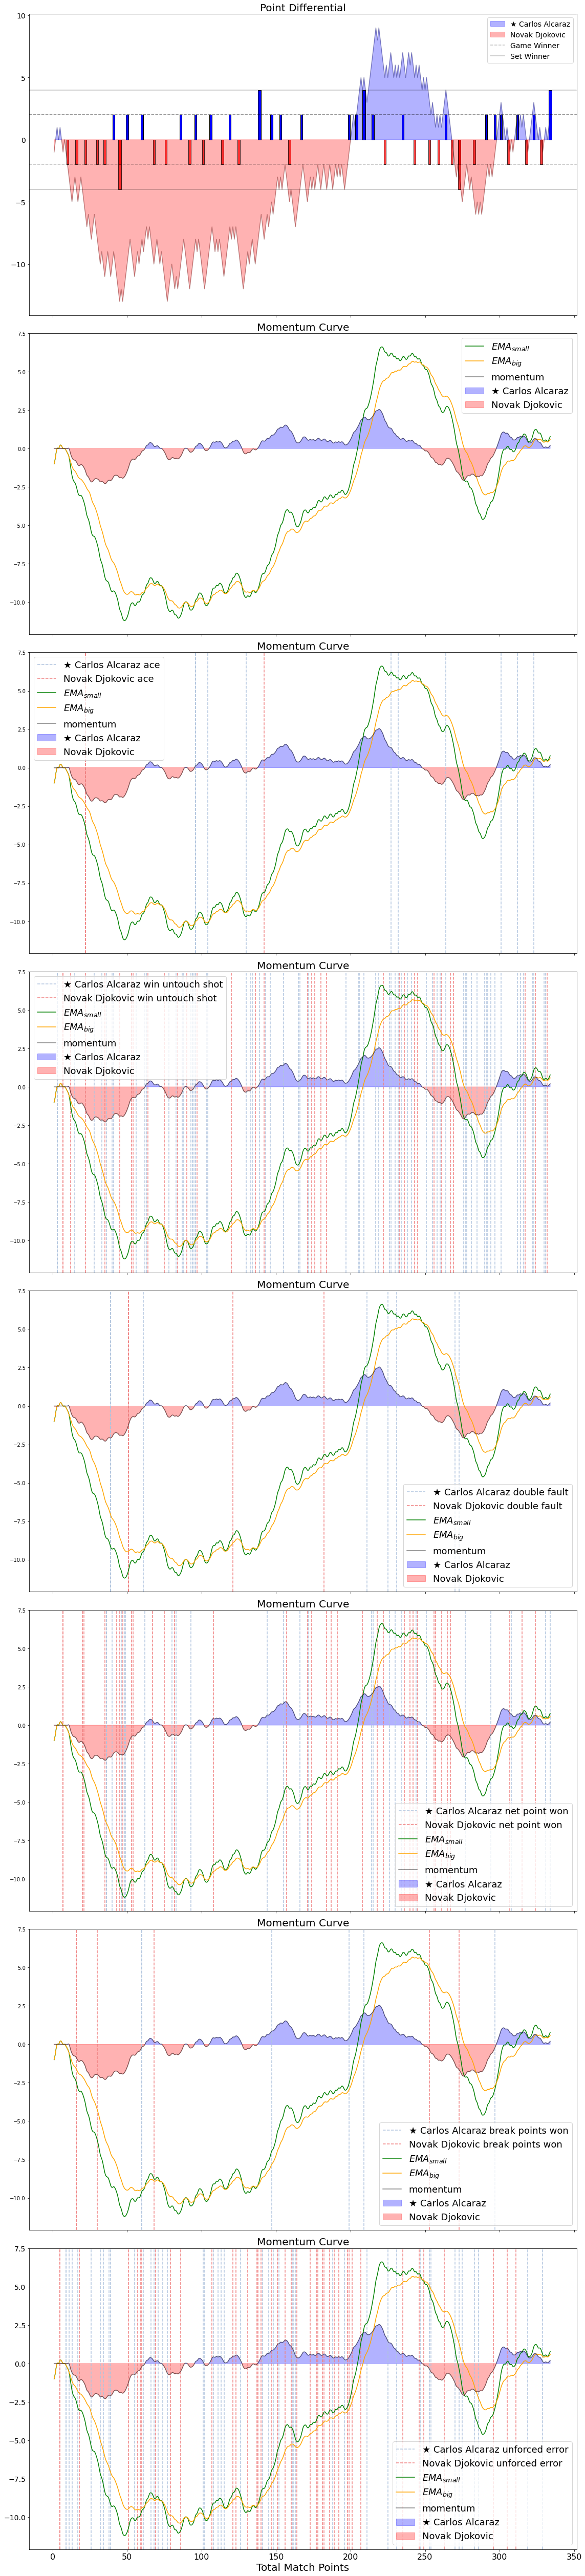

In [8]:
def newMCAD(target, small_ema, large_ema, macd, points, winner, player_1, player_2):
    values = np.array(target)

    small_ema = smoothing(points,small_ema,3)
    large_ema = smoothing(points,large_ema,3)
    values = smoothing(points, values, 1)
    macd = smoothing(points, macd, 3)
    

    points = np.linspace(points.min(), points.max(), 1000)

    if(winner == 1):
        player_1 = "★ " + player_1
    else:
        player_2 = "★ " + player_2
    
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize=(16, 70), sharex=True)


    last_instance_indices = game.groupby(['set_no', 'game_no'])['point_no'].idxmax()
    last_instance_points = game.loc[last_instance_indices, ['set_no', 'game_no', 'point_no', 'point_differential', 'point_victor']]

    last_set_indices = game.groupby('set_no')['point_no'].idxmax()
    last_set_points = game.loc[last_set_indices, ['set_no', 'game_no', 'point_no', 'point_differential', 'point_victor']]

    for point in game[game['ace_diff'] == 1]['point_no']:
        ax3.axvline(x=point, color='lightsteelblue', linestyle='--')
    ax3.axvline(x= game[game['ace_diff'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} ace')
    
    for point in game[game['ace_diff'] == -1]['point_no']:
        ax3.axvline(x=point, color='lightcoral', linestyle='--')
    ax3.axvline(x= game[game['ace_diff'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} ace')

    for point in game[game['win_untouchshot_diff'] == 1]['point_no']:
        ax4.axvline(x=point, color='lightsteelblue', linestyle='--')
    ax4.axvline(x= game[game['win_untouchshot_diff'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} win untouch shot')

    for point in game[game['win_untouchshot_diff'] == -1]['point_no']:
        ax4.axvline(x=point, color='lightcoral', linestyle='--')
    ax4.axvline(x= game[game['win_untouchshot_diff'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} win untouch shot')

    for point in game[game['double_fault_diff'] == 1]['point_no']:
        ax5.axvline(x=point, color='lightsteelblue', linestyle='--')
    if(len(game[game['double_fault_diff'] == 1]['point_no'].values) > 0):
        ax5.axvline(x= game[game['double_fault_diff'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} double fault')

    for point in game[game['double_fault_diff'] == -1]['point_no']:
        ax5.axvline(x=point, color='lightcoral', linestyle='--')
    if(len(game[game['double_fault_diff'] == -1]['point_no'].values) > 0):
        ax5.axvline(x= game[game['double_fault_diff'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} double fault')
        
    for point in game[game['net_pt_won_diff'] == 1]['point_no']:
        ax6.axvline(x=point, color='lightsteelblue', linestyle='--')
    ax6.axvline(x= game[game['net_pt_won_diff'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} net point won')

    for point in game[game['net_pt_won_diff'] == -1]['point_no']:
        ax6.axvline(x=point, color='lightcoral', linestyle='--')
    ax6.axvline(x= game[game['net_pt_won_diff'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} net point won')

    for point in game[game['point_break_diff'] == 1]['point_no']:
        ax7.axvline(x=point, color='lightsteelblue', linestyle='--')
    ax7.axvline(game[game['point_break_diff'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} break points won')

    for point in game[game['point_break_diff'] == -1]['point_no']:
        ax7.axvline(x=point, color='lightcoral', linestyle='--')
    if(len(game[game['point_break_diff'] == -1]['point_no']) > 0):
        ax7.axvline(game[game['point_break_diff'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} break points won')

    for point in game[game['unf_err'] == 1]['point_no']:
        ax8.axvline(x=point, color='lightsteelblue', linestyle='--')
    ax8.axvline(x= game[game['unf_err'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} unforced error')

    for point in game[game['unf_err'] == -1]['point_no']:
        ax8.axvline(x=point, color='lightcoral', linestyle='--')
    ax8.axvline(x= game[game['unf_err'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} unforced error')

    
    ax1.plot(points, values, color='black', alpha=0.25)
    ax1.fill_between(points, values, color='blue', where=(values > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax1.fill_between(points, values, color='red', where=(values < 0), interpolate=True, alpha=0.3, label=f'{player_2}')

    winner_points_1 = last_instance_points[last_instance_points['point_victor'] == 1]
    ax1.bar(winner_points_1['point_no'], 2, width=1.5, color='blue',edgecolor='black')

    winner_points_2 = last_instance_points[last_instance_points['point_victor'] == 2]
    ax1.bar(winner_points_2['point_no'], -2, width=1.5, color='red',edgecolor='black',  alpha = 0.75)

    winner_set_points_1 = last_set_points[last_set_points['point_victor'] == 1]
    ax1.bar(winner_set_points_1['point_no'], 4, width=2, color='blue',edgecolor='black')

    winner_set_points_2 = last_set_points[last_set_points['point_victor'] == 2]
    ax1.bar(winner_set_points_2['point_no'], -4, width=2, color='red', edgecolor='black', alpha = 0.75)

    ax1.axhline(y=2, color='black', linestyle='--', alpha=0.5)
    ax1.axhline(y=-2, color='black', linestyle='--', alpha=0.25, label='Game Winner')
    ax1.axhline(y=4, color='black', linestyle='-', alpha=0.25)
    ax1.axhline(y=-4, color='black', linestyle='-', alpha=0.25, label='Set Winner')
    ax1.legend(fontsize=14)
    ax1.set_title('Point Differential', fontsize=20)
    ax1.tick_params(axis='y', labelsize=14)

    ax2.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax2.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax2.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax2.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax2.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax2.legend(fontsize=18)
    ax2.set_title('Momentum Curve', fontsize=20)
    
    ax3.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax3.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax3.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax3.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax3.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax3.legend(fontsize=18)
    ax3.set_title('Momentum Curve', fontsize=20)

    ax4.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax4.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax4.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax4.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax4.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax4.legend(fontsize=18)
    ax4.set_title('Momentum Curve', fontsize=20)

    ax5.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax5.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax5.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax5.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax5.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax5.legend(fontsize=18)
    ax5.set_title('Momentum Curve', fontsize=20)

    ax6.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax6.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax6.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax6.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax6.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax6.legend(fontsize=18)
    ax6.set_title('Momentum Curve', fontsize=20)

    ax7.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax7.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax7.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax7.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax7.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax7.legend(fontsize=18)
    ax7.set_title('Momentum Curve', fontsize=20)

    ax8.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax8.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax8.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax8.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax8.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax8.legend(fontsize=18)
    ax8.set_title('Momentum Curve', fontsize=20)

    plt.xlabel('Total Match Points', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

def smoothing(x, y, k):
    spl = make_interp_spline(x, y, k=k)
    x_smooth = np.linspace(x.min(), x.max(), 1000)
    y_smooth = spl(x_smooth)
    return  y_smooth

#Change match_id_int to desired match id 
game = df[df["match_id_int"] == 1701]

newMCAD(game['point_differential'], game['ema_small'], game['ema_big'], game['momentum'], game['point_no'], game['winners'].max(), game['player1'].min(), game['player2'].min())


## Momentum Curve with statistically significant confidence effecting events 

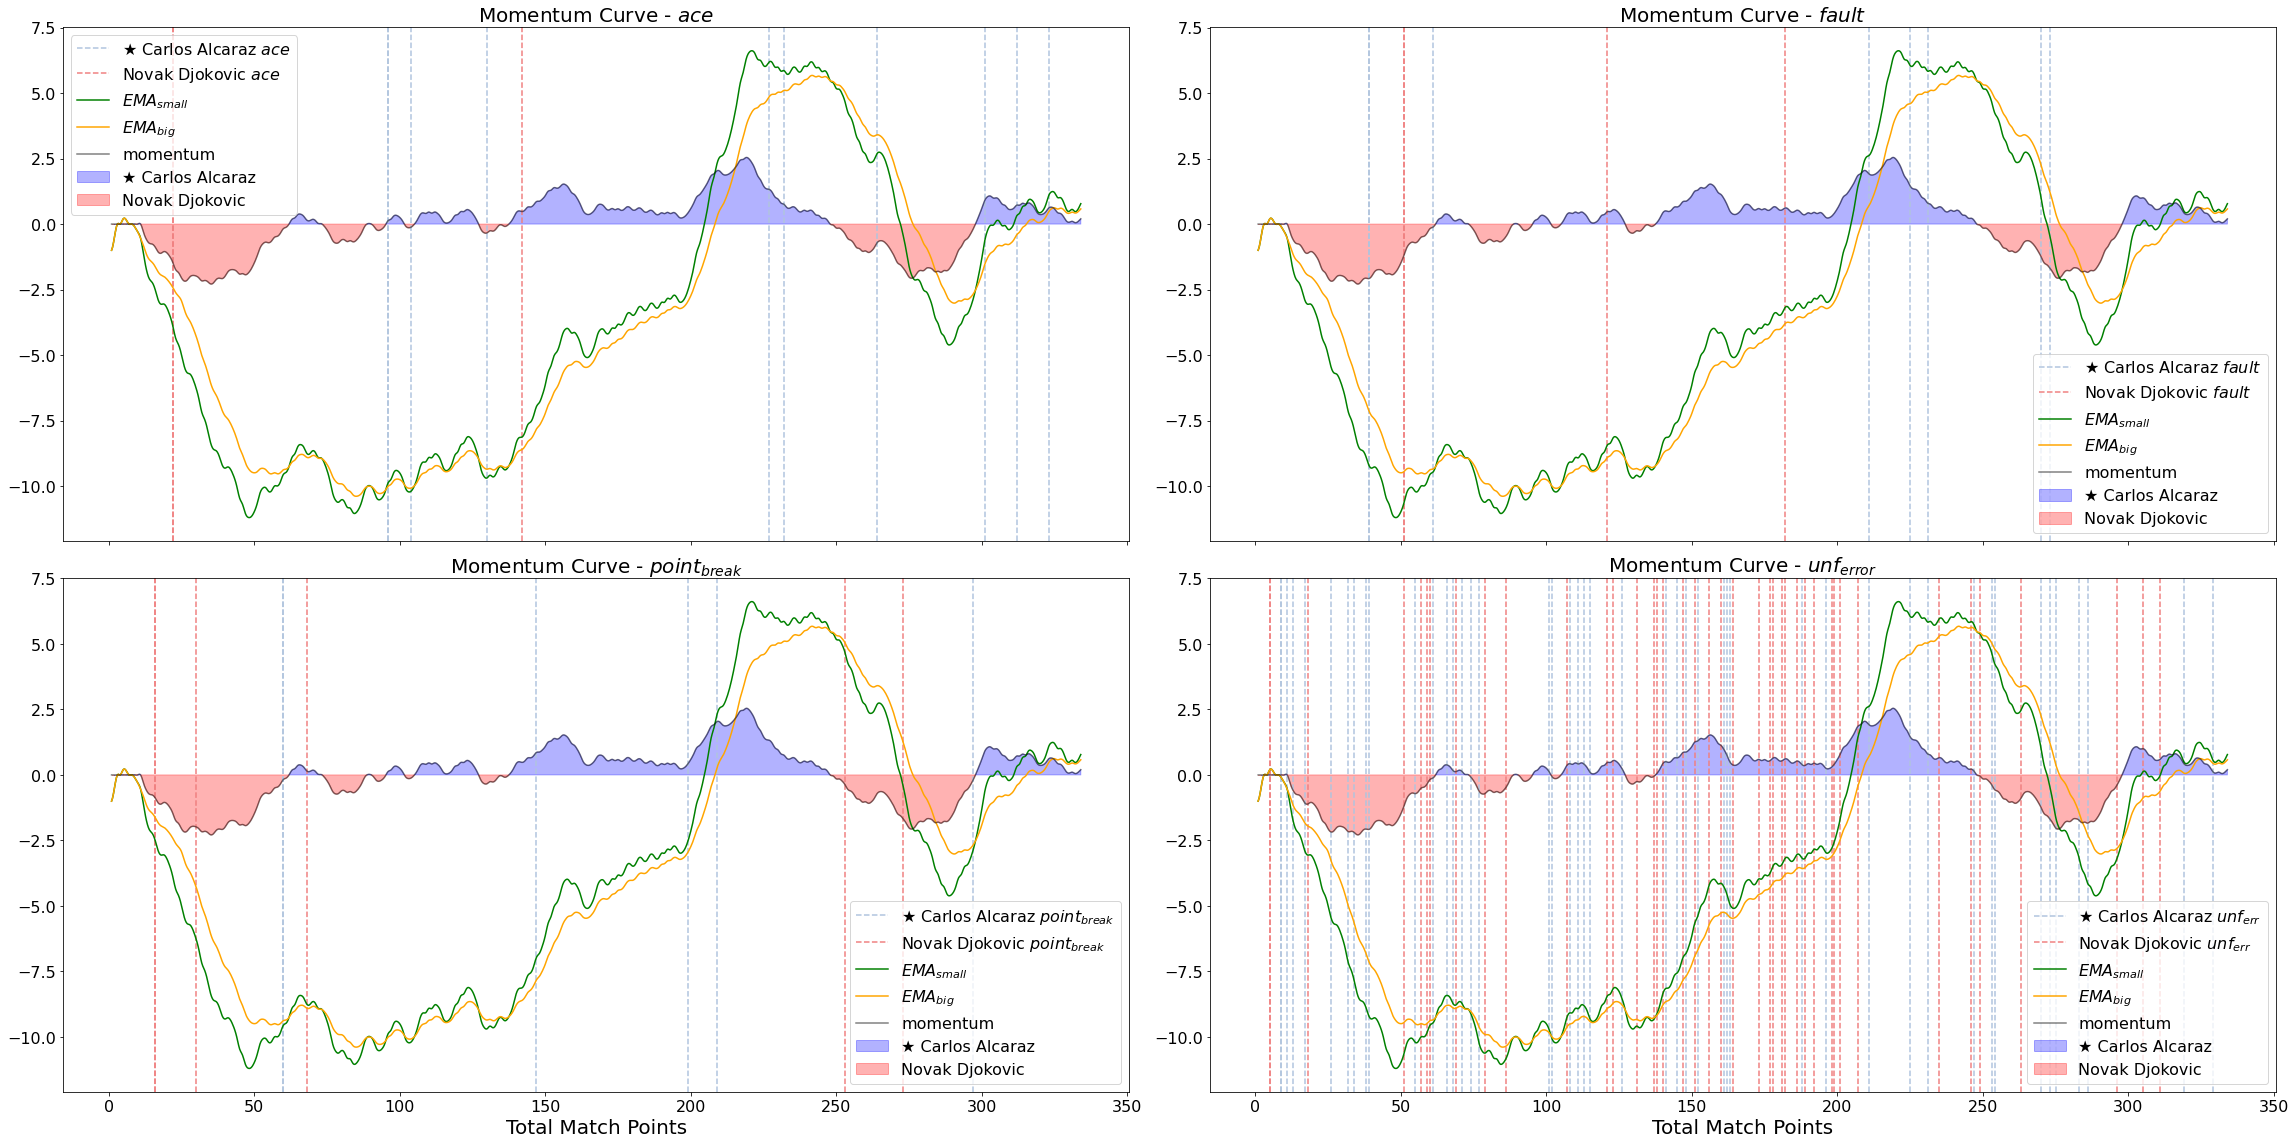

In [9]:
def newMCAD(target, small_ema, large_ema, macd, points, winner, player_1, player_2):
    values = np.array(target)

    small_ema = smoothing(points,small_ema,3)
    large_ema = smoothing(points,large_ema,3)
    values = smoothing(points, values, 1)
    macd = smoothing(points, macd, 3)
    

    points = np.linspace(points.min(), points.max(), 1000)

    if(winner == 1):
        player_1 = "★ " + player_1
    else:
        player_2 = "★ " + player_2
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(32, 16), sharex=True)

    doublefault = '$fault$'
    pointbreak = '$point_{break}$'
    unferr = '$unf_{err}$'
    ace = '$ace$'
  
    for point in game[game['ace_diff'] == 1]['point_no']:
        ax1.axvline(x=point, color='lightsteelblue', linestyle='--')
    ax1.axvline(x= game[game['ace_diff'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} {ace}')
    
    for point in game[game['ace_diff'] == -1]['point_no']:
        ax1.axvline(x=point, color='lightcoral', linestyle='--')
    ax1.axvline(x= game[game['ace_diff'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} {ace}')

    for point in game[game['double_fault_diff'] == 1]['point_no']:
        ax2.axvline(x=point, color='lightsteelblue', linestyle='--')
    if(len(game[game['double_fault_diff'] == 1]['point_no'].values) > 0):
        ax2.axvline(x= game[game['double_fault_diff'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} {doublefault}')

    for point in game[game['double_fault_diff'] == -1]['point_no']:
        ax2.axvline(x=point, color='lightcoral', linestyle='--')
    if(len(game[game['double_fault_diff'] == -1]['point_no'].values) > 0):
        ax2.axvline(x= game[game['double_fault_diff'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} {doublefault}')

    for point in game[game['point_break_diff'] == 1]['point_no']:
        ax3.axvline(x=point, color='lightsteelblue', linestyle='--')
    ax3.axvline(game[game['point_break_diff'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} {pointbreak}')

    for point in game[game['point_break_diff'] == -1]['point_no']:
        ax3.axvline(x=point, color='lightcoral', linestyle='--')
    if(len(game[game['point_break_diff'] == -1]['point_no']) > 0):
        ax3.axvline(game[game['point_break_diff'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} {pointbreak}')

    for point in game[game['unf_err'] == 1]['point_no']:
        ax4.axvline(x=point, color='lightsteelblue', linestyle='--')
    ax4.axvline(x= game[game['unf_err'] == 1]['point_no'].values[0], color='lightsteelblue', linestyle='--', label=f'{player_1} {unferr}')

    for point in game[game['unf_err'] == -1]['point_no']:
        ax4.axvline(x=point, color='lightcoral', linestyle='--')
    ax4.axvline(x= game[game['unf_err'] == -1]['point_no'].values[0], color='lightcoral', linestyle='--', label=f'{player_2} {unferr}')

    ax1.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax1.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax1.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax1.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax1.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax1.legend(fontsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.set_title('Momentum Curve - $ace$', fontsize=20)

    ax2.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax2.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax2.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax2.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax2.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax2.legend(fontsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    ax3.tick_params(axis='x', labelsize=16)
    ax2.set_title('Momentum Curve - $fault$', fontsize=20)
    
    ax3.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax3.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax3.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax3.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax3.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax3.legend(fontsize=16)
    ax3.tick_params(axis='y', labelsize=16)
    ax3.tick_params(axis='x', labelsize=16)
    ax3.set_xlabel('Total Match Points', fontsize = 20)
    ax3.set_title('Momentum Curve - $point_{break}$', fontsize=20)

    ax4.plot(points, small_ema, color='green', label='$EMA_{small}$')
    ax4.plot(points, large_ema, color='orange', label='$EMA_{big}$')
    ax4.plot(points, macd, color='black', label='momentum', alpha = 0.5)
    ax4.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax4.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')
    ax4.legend(fontsize=16)
    ax4.set_title('Momentum Curve - $unf_{error}$', fontsize=20)
    
    plt.xlabel('Total Match Points', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

def smoothing(x, y, k):
    spl = make_interp_spline(x, y, k=k)
    x_smooth = np.linspace(x.min(), x.max(), 1000)
    y_smooth = spl(x_smooth)
    return  y_smooth


newMCAD(game['point_differential'], game['ema_small'], game['ema_big'], game['momentum'], game['point_no'], game['winners'].max(), game['player1'].min(), game['player2'].min())




## Correlation Heat Map between all psychological events and momentum

Correlation and P-Value DataFrame:
                      Correlation       P-Value
ace_diff                 0.017485  1.356573e-01
win_untouchshot_diff     0.027123  2.061825e-02
double_fault_diff       -0.034227  3.483604e-03
net_pt_won_diff         -0.003126  7.896767e-01
point_break_diff         0.121132  3.234598e-25
unf_err                 -0.074745  1.691491e-10


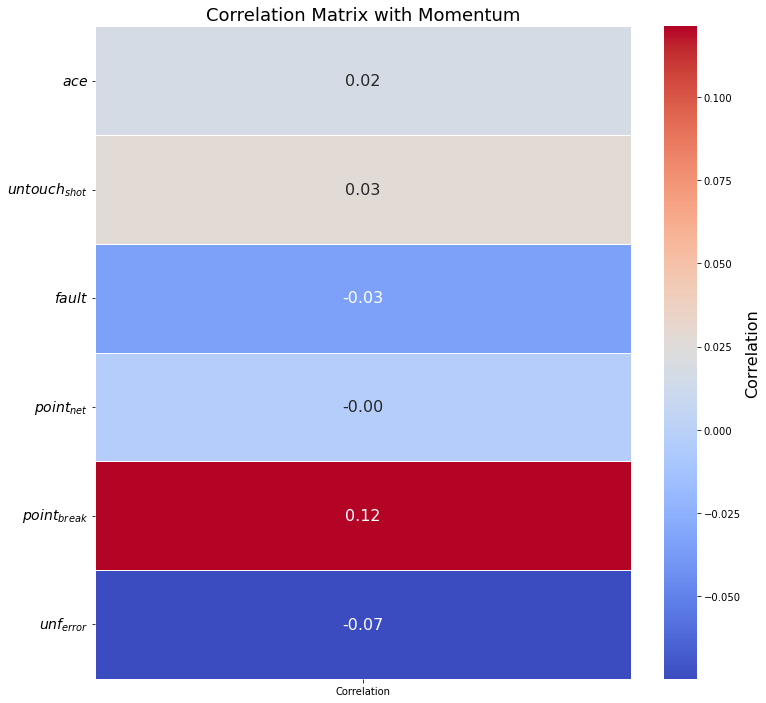

In [10]:
correlation_matrix_column1, p_values = [], []
confidences_variables = ['ace_diff', 'win_untouchshot_diff', 'double_fault_diff', 'net_pt_won_diff', 'point_break_diff', 'unf_err']
for var in confidences_variables:
    corr, p_value = pearsonr(df[var], df['momentum'])
    correlation_matrix_column1.append(corr)
    p_values.append(p_value)

result_df = pd.DataFrame({'Correlation': correlation_matrix_column1, 'P-Value': p_values}, confidences_variables)
print("Correlation and P-Value DataFrame:")
print(result_df)

y_axis_labels = ['$ace$', '$untouch_{shot}$', '$fault$', '$point_{net}$', '$point_{break}$', '$unf_{error}$']  # Replace with your actual labels

plt.figure(figsize=(12, 12))

plt.title('Correlation Matrix with Momentum', fontsize=18)

heatmap = sns.heatmap(result_df[['Correlation']], cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5,
                      annot_kws={"size": 16})

heatmap.set_yticklabels(y_axis_labels, rotation=0, fontsize=14)

heatmap.collections[0].colorbar.set_label('Correlation', fontsize=16)

plt.show()


## Violin Plots of the Statistically Significant Psychological Variables and Momentum for all Data

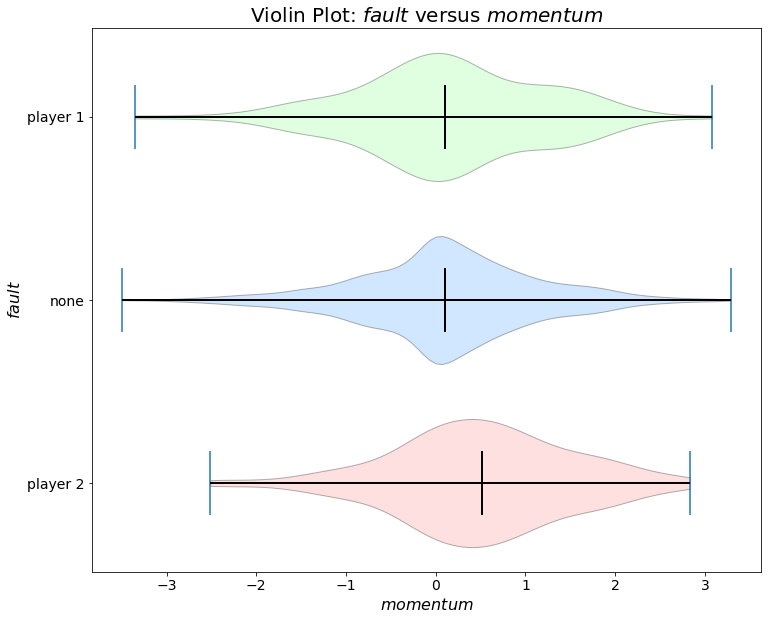

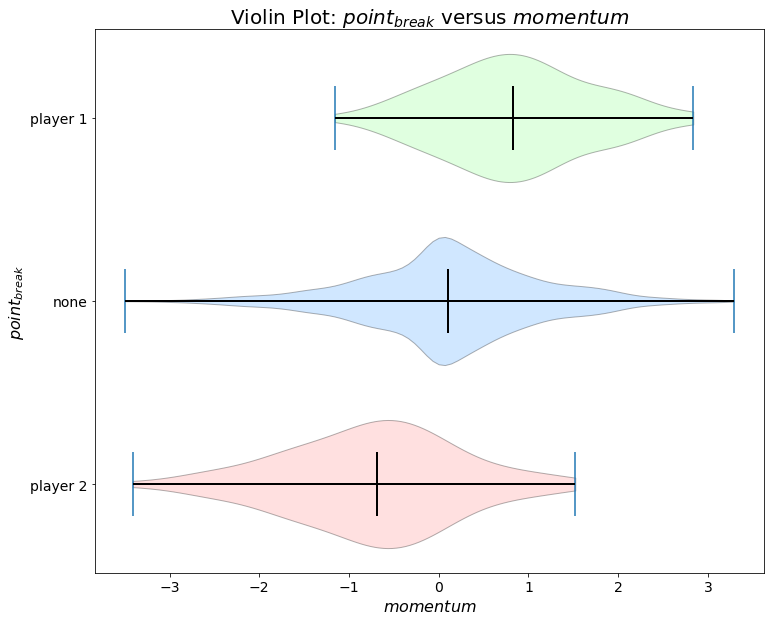

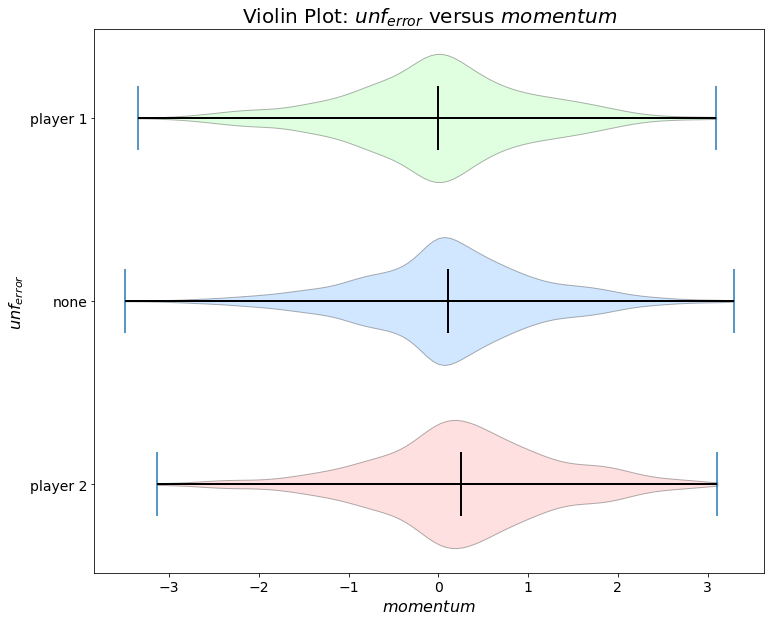

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def corrPlot(name, var):
    colors = ['#FF9999', '#66B2FF', '#99FF99']


    fig, ax = plt.subplots(figsize=(12, 10))


    violin_parts = ax.violinplot(dataset=[df[df[name] == value]['momentum'] for value in [-1, 0, 1]],
                                positions=[-1, 0, 1], showmedians=True, widths=0.7, vert=False)


    for i, body in enumerate(violin_parts['bodies']):
        body.set_facecolor(colors[i])
        body.set_edgecolor('black')


    ax.set_yticks([-1,0,1])
    ax.set_yticklabels(['player 2', 'none', 'player 1'], fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_ylabel(var, fontsize=16)
    ax.set_xlabel('$momentum$', fontsize=16)
    ax.set_title(f'Violin Plot: {var} versus $momentum$', fontsize=20)

    for partname in ('cbars', 'cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(2)

    plt.show()

for name, var in [ ['double_fault_diff', '$fault$'], ['point_break_diff', '$point_{break}$'], ['unf_err', '$unf_{error}$']]:
    corrPlot(name, var)

## Violin Plots of Correlations for each event and momentum for a game.

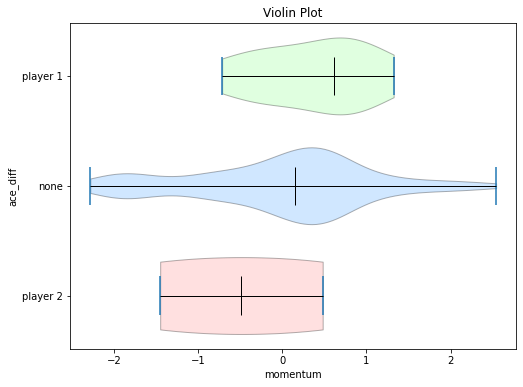

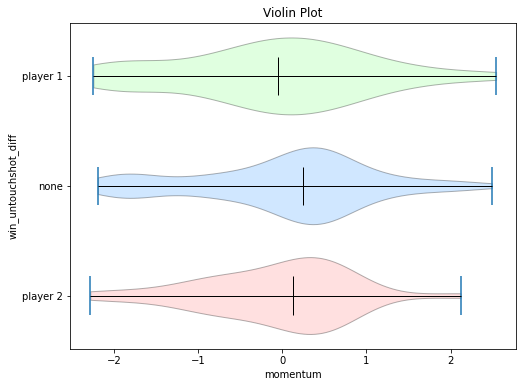

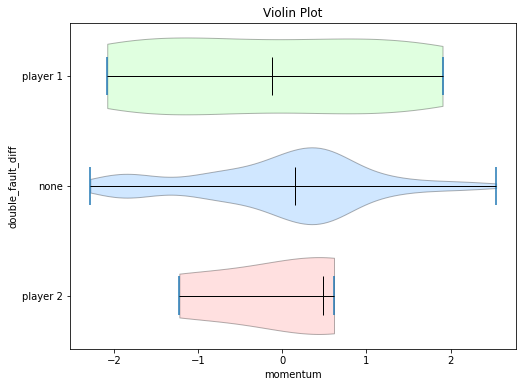

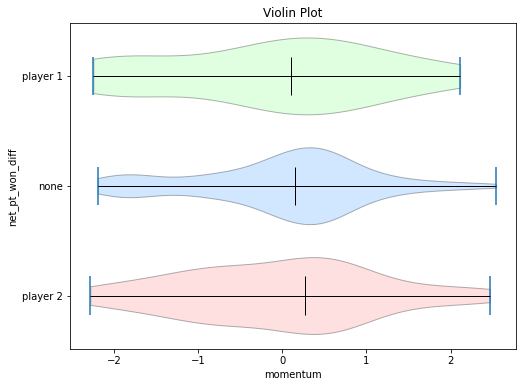

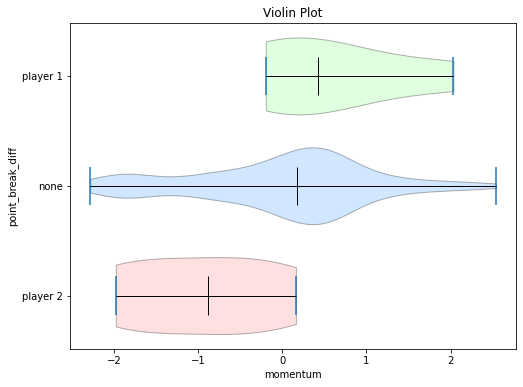

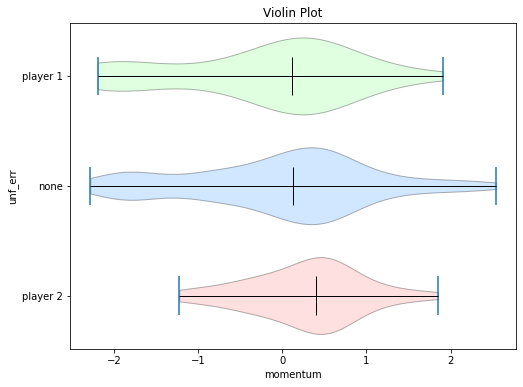

Carlos Alcaraz
Novak Djokovic


In [12]:
def corrPlot(name):
    colors = ['#FF9999', '#66B2FF', '#99FF99']

    fig, ax = plt.subplots(figsize=(8, 6))

    violin_parts = ax.violinplot(dataset=[game[game[name] == value]['momentum'] for value in [-1, 0, 1]],
                                positions=[-1, 0, 1], showmedians=True, widths=0.7, vert=False)

    for i, body in enumerate(violin_parts['bodies']):
        body.set_facecolor(colors[i])
        body.set_edgecolor('black')

    ax.set_yticks([-1,0,1])
    ax.set_yticklabels(['player 2', 'none', 'player 1'])
    ax.set_ylabel(f'{name}')
    ax.set_xlabel('momentum')
    ax.set_title('Violin Plot')

    # Customize median line
    for partname in ('cbars', 'cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

    plt.show()


game = df[df["match_id_int"] == 1701]

for name in ['ace_diff', 'win_untouchshot_diff', 'double_fault_diff', 'net_pt_won_diff', 'point_break_diff', 'unf_err']:
    corrPlot(name)

print(game['player1'].min())
print(game['player2'].min())


## Trial and Error Data Testing + Interesting Results

## Calculating the probability of winning the point if player is serving

In [13]:
# the following lines will print the stats about if a player is server and who won the point.
df.groupby(['server', 'point_victor']).size().reset_index(name='count')

winning_total_server = 2452+2451
losing_total_server = 1115+1266
total = winning_total_server + losing_total_server
avg_percentage_win_serving = winning_total_server / (winning_total_server+losing_total_server)

print(avg_percentage_win_serving)
print(total)
print(winning_total_server)


observed_proportion = winning_total_server / total


contingency_table = [winning_total_server, total-winning_total_server]


chi2, p_value, _, _ = chi2_contingency(contingency_table)


print("p-value:", p_value)

if p_value < 0.05:
    print("Statistically significant: Reject the null hypothesis")
else:
    print("Not statistically significant: Fail to reject the null hypothesis")

0.6731191652937946
7284
4903
p-value: 1.0
Not statistically significant: Fail to reject the null hypothesis


### Plot of the point differential, player's streaks, and pointers for the end of a game or set

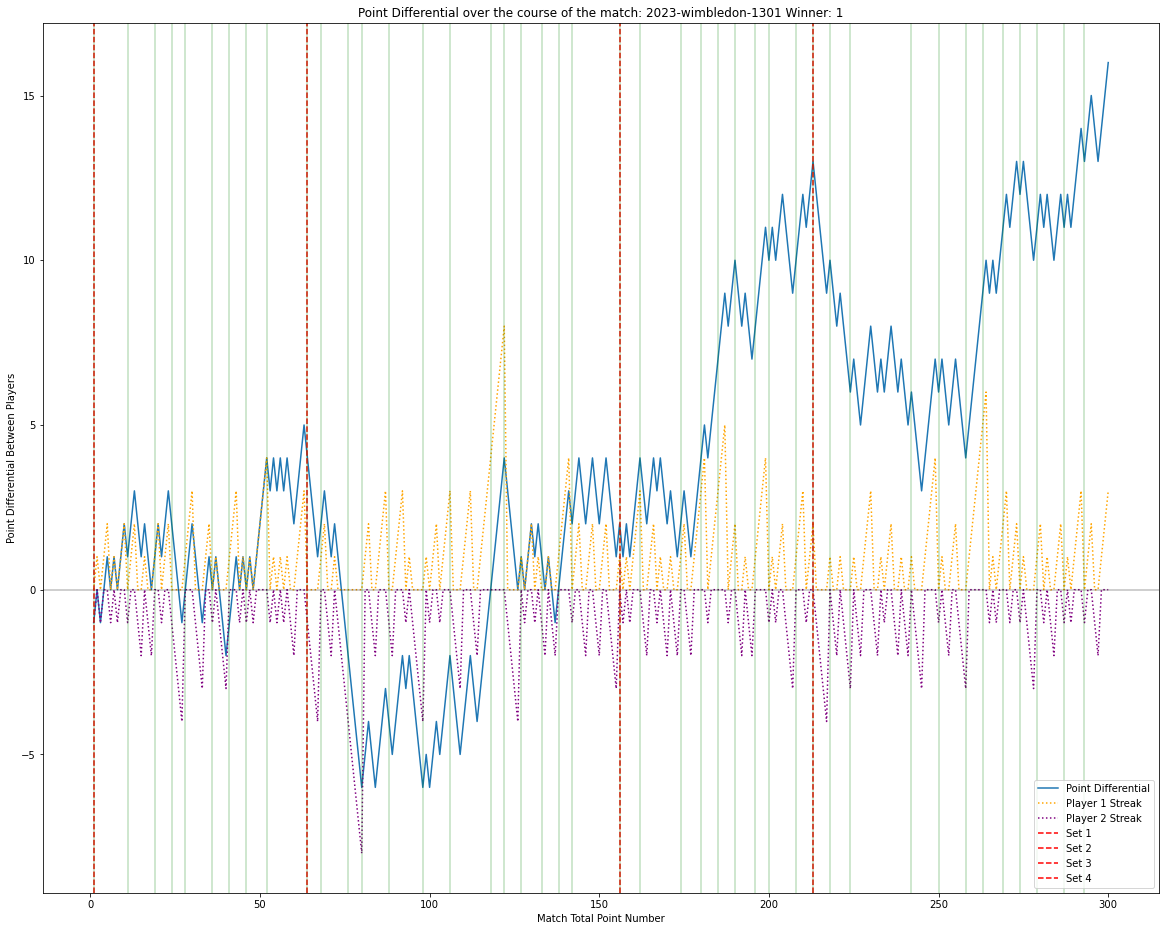

In [14]:
game = df[df['match_id'] == '2023-wimbledon-1301']
winner = game['winners'].values[0]
first_instance_indices = game.groupby(['set_no', 'game_no'])['point_no'].idxmin()
first_instance_points = game.loc[first_instance_indices, ['set_no', 'game_no', 'point_no', 'point_differential']]

first_set_indices = game.groupby('set_no')['point_no'].idxmin()
first_set_points = game.loc[first_set_indices, ['set_no', 'game_no', 'point_no', 'point_differential']]

plt.figure(figsize=(20,16))
plt.plot(game['point_no'], game['point_differential'], label='Point Differential')
plt.plot(game['point_no'], game['player1_streak'], label='Player 1 Streak', color = 'orange', linestyle = 'dotted', alpha = 1)
plt.plot(game['point_no'], -game['player2_streak'], label='Player 2 Streak', color = 'purple', linestyle = 'dotted', alpha = 1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.25)  # Add a dashed line at y=0 for reference
i = 1
for idx, row in first_set_points.iterrows():
    plt.axvline(x=row['point_no'], color='red', linestyle='--', label=f'Set {i}')
    i = i + 1


for idx, row in first_instance_points.iterrows():
    plt.axvline(x=row['point_no'], color='green', alpha = 0.25)

plt.xlabel('Match Total Point Number')
plt.ylabel('Point Differential Between Players')
plt.title(f'Point Differential over the course of the match: 2023-wimbledon-1301 Winner: 1')


plt.legend()

plt.show()




### Plot of Point Different and Streak against total points in match

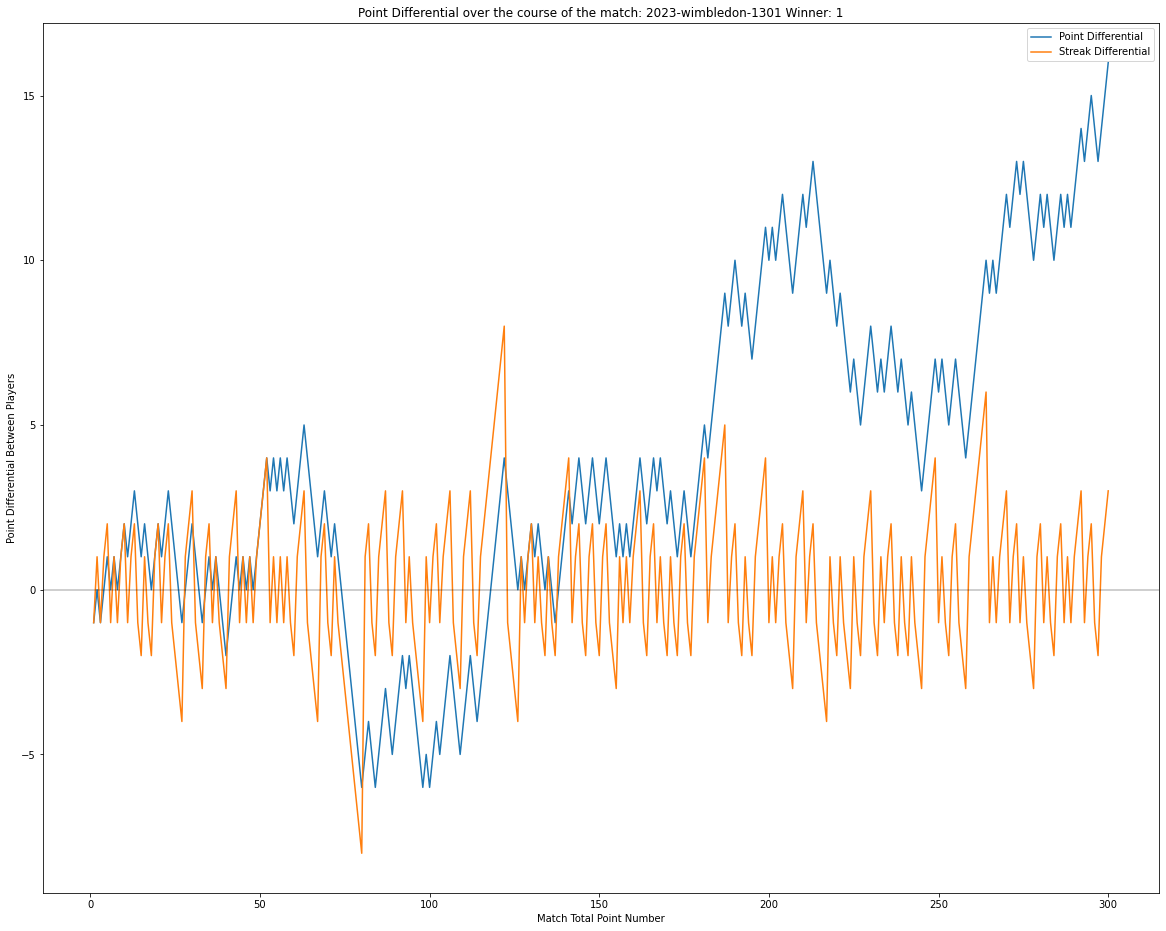

In [15]:
game = df[df['match_id'] == '2023-wimbledon-1301']

plt.figure(figsize=(20,16))
plt.plot(game['point_no'], game['point_differential'], label='Point Differential')
plt.plot(game['point_no'], game['streak_differential'], label='Streak Differential')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.25)  # Add a dashed line at y=0 for reference

plt.xlabel('Match Total Point Number')
plt.ylabel('Point Differential Between Players')
plt.title(f'Point Differential over the course of the match: 2023-wimbledon-1301 Winner: 1')

plt.legend()

plt.show()

### First Ever Plot of Momentum 

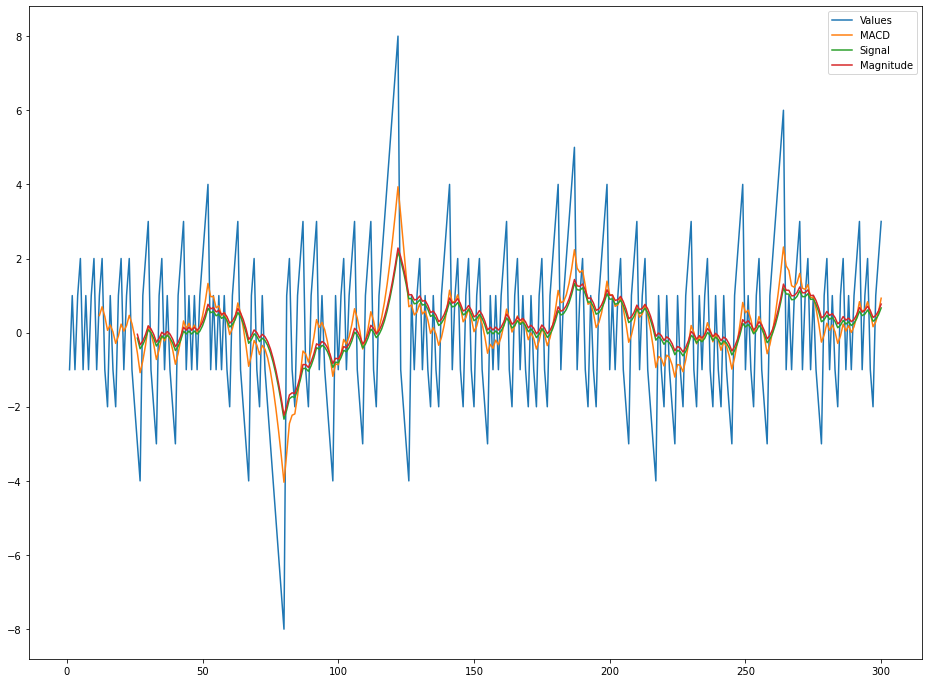

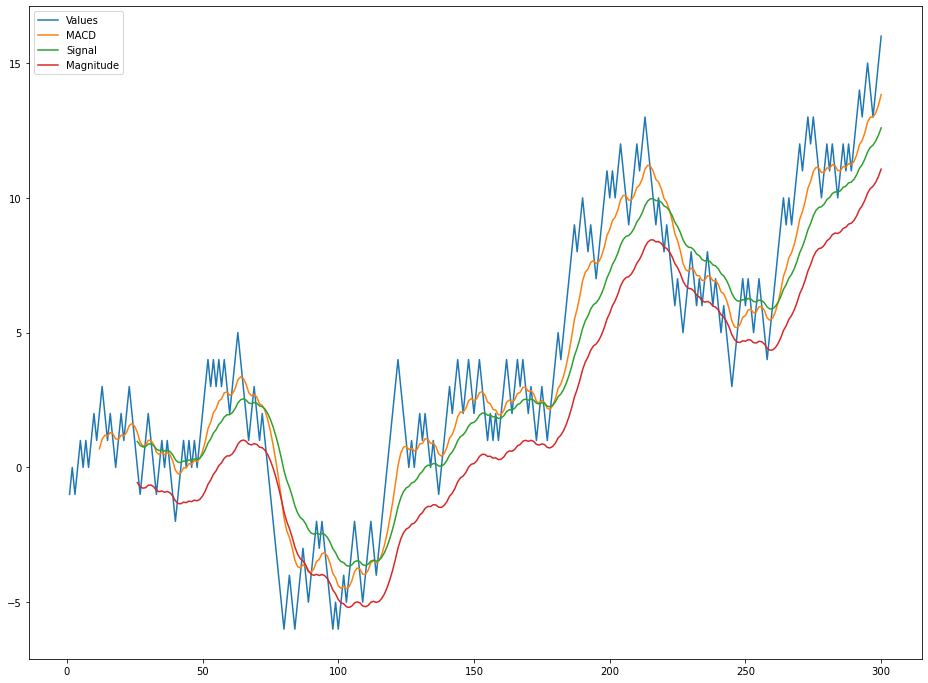

In [16]:

def MCAD(target, points, fwin, swin):
    values = np.array(target)
    small_ema = calcEMA(values, fwin)
    large_ema = calcEMA(values, swin)
    macd = np.subtract(small_ema[(swin-fwin)-1], large_ema)

    plt.figure(figsize=(16,12))
    plt.plot(points, values, label='Values')
    plt.plot(points[fwin-1:], small_ema, label=f'MACD')
    plt.plot(points[swin-1:], large_ema, label=f'Signal')
    plt.plot(points[swin-1:], -macd, label='Magnitude')
    plt.legend()
    plt.show()


def calcEMA(values, win):
    arr = []
    for i in range(win-1, len(values)):
        if len(arr) == 0:
            arr.append(np.average(values[0:win+1]))
        else:
            small_avg = arr[len(arr)-1] 
            ema_calc = (values[i] - small_avg) * (2/(win+1)) + small_avg
            arr.append(ema_calc)
    return arr


game = df[df['match_id'] == '2023-wimbledon-1301']
MCAD(game['streak_differential'], game['point_no'], 12, 26)
MCAD(game['point_differential'], game['point_no'], 12, 26)

### Observing Data for Winners and Losers of Matches

In [17]:
sum_df = pd.DataFrame()

columnsToSum = ['p1_ace', 'p2_ace', 'p1_winner', 'p2_winner', 
       'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err',
       'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won', 'p2_net_pt_won',
       'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won', 'p2_break_pt_won',
       'p1_break_pt_missed', 'p2_break_pt_missed', 'p1_distance_run',
       'p2_distance_run']

for column in columnsToSum:
       sum_df[column] = df.groupby('match_id')[column].sum()


temp = df.groupby(['match_id', 'server', 'serve_no']).size()
temp
player1_oneserve = []
player1_twoserve = []

player2_oneserve = []
player2_twoserve = []

for i in range(0,len(temp), 4):
    player1_oneserve.append(temp[i])
    player1_twoserve.append(temp[i+1])
    player2_oneserve.append(temp[i+2])
    player2_twoserve.append(temp[i+3])

sum_df['p1_serve_1'] = np.array(player1_oneserve)
sum_df['p1_serve_2'] = np.array(player1_twoserve)
sum_df['p2_serve_1'] = np.array(player2_oneserve)
sum_df['p2_serve_2'] = np.array(player2_twoserve)

sum_df['winner']=df.groupby('match_id')['winners'].max()
sum_df['loser'] = sum_df['winner'].apply(lambda x: 2 if x == 1 else 1)

sum_df['point_time_avg'] = df.groupby('match_id')['point_time'].mean()
sum_df['rally_count_avg'] = df.groupby('match_id')['rally_count'].mean()

temp = df.groupby(['match_id', 'server', 'serve_no'])['speed_mph'].mean()
player1_oneserve_mph = []
player1_twoserve_mph = []

player2_oneserve_mph = []
player2_twoserve_mph = []

for i in range(0,len(temp), 4):
    player1_oneserve_mph.append(temp[i])
    player1_twoserve_mph.append(temp[i+1])
    player2_oneserve_mph.append(temp[i+2])
    player2_twoserve_mph.append(temp[i+3])

sum_df['p1_serve_1_mph'] = np.array(player1_oneserve_mph)
sum_df['p1_serve_2_mph'] = np.array(player1_twoserve_mph)
sum_df['p2_serve_1_mph'] = np.array(player2_oneserve_mph)
sum_df['p2_serve_2_mph'] = np.array(player2_twoserve_mph)

sum_df['point_differential'] = lastrows['point_differential']


#### Correlation Heat Map of Winners and Losers

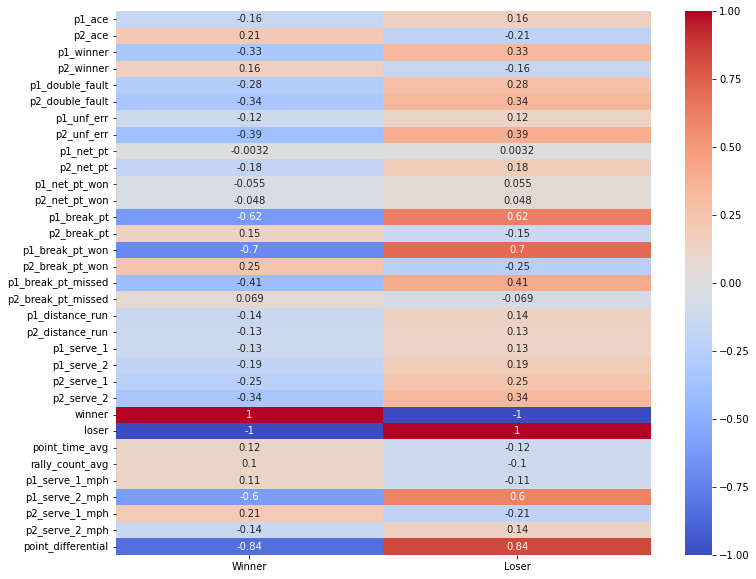

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import datasets  
import pandas as pd 
 
correlation_matrix_column1 = sum_df.corrwith(sum_df['winner'])

correlation_matrix_column2 = sum_df.corrwith(sum_df['loser'])

correlation_df = pd.DataFrame({'Winner': correlation_matrix_column1, 'Loser': correlation_matrix_column2})
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_df, cmap="coolwarm", annot=True)

plt.show()

#### Splitting Data into Winner and Loser Data Frames

In [19]:

p1_colnames = ['winner', 'loser', 'p1_ace', 'p1_winner',  'p1_double_fault',
        'p1_unf_err',  'p1_net_pt', 
       'p1_net_pt_won', 'p1_break_pt',
       'p1_break_pt_won', 'p1_break_pt_missed',
     'p1_distance_run', 
       'p1_serve_1', 'p1_serve_2', 'p1_serve_1_mph',
       'p1_serve_2_mph']

p2_colnames = ['winner', 'loser','p2_ace', 'p2_winner', 'p2_double_fault', 'p2_unf_err', 'p2_net_pt', 'p2_net_pt_won', 'p2_break_pt', 'p2_break_pt_won', 'p2_break_pt_missed', 'p2_distance_run', 'p2_serve_1', 'p2_serve_2', 'p2_serve_1_mph', 'p2_serve_2_mph']

p1_winner = sum_df[sum_df['winner'] == 1].drop(columns=p2_colnames, axis=1)
p2_winner = sum_df[sum_df['winner'] == 2].drop(columns=p1_colnames, axis=1)

colnames = ['ace', 'winner', 'double_fault', 'unf_err', 'net_pt', 'net_pt_won', 'break_pt', 'break_pt_won',
            'break_pt_missed', 'distance_run', 'serve_1', 'serve_2', 'point_time_avg', 'rally_count_avg',
            'serve_1_mph', 'serve_2_mph', 'point_differential']

p1_winner.rename(columns=dict(zip(p1_winner.columns, colnames)), inplace=True)
p2_winner.rename(columns=dict(zip(p2_winner.columns, colnames)), inplace=True)

df_winners = pd.concat([p1_winner, p2_winner], ignore_index=True)


p1_loser = sum_df[sum_df['loser'] == 1].drop(columns=p2_colnames, axis=1)
p2_loser = sum_df[sum_df['loser'] == 2].drop(columns=p1_colnames, axis=1)

p1_loser.rename(columns=dict(zip(p1_loser.columns, colnames)), inplace=True)
p2_loser.rename(columns=dict(zip(p2_loser.columns, colnames)), inplace=True)

df_loser = pd.concat([p1_loser, p2_loser], ignore_index=True)

df_winners.fillna(-1, inplace=True)
df_loser.fillna(-1, inplace=True)

#### Correlation Testing for Winners and Loser DataFrames

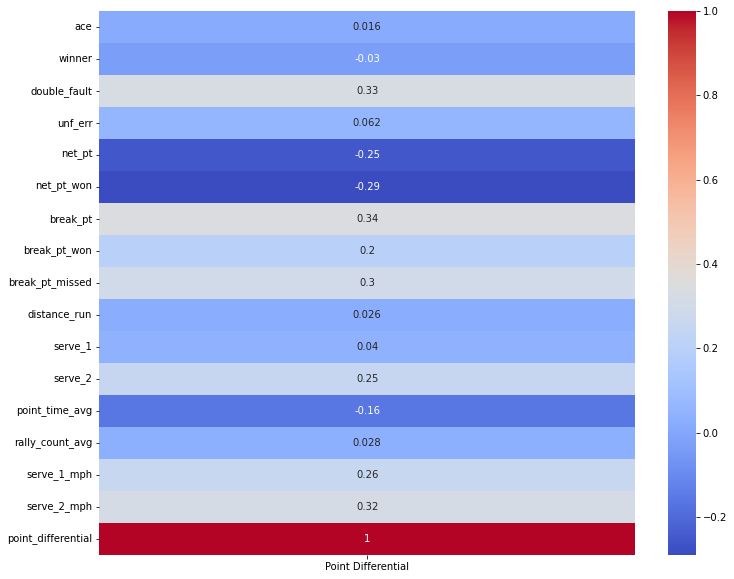

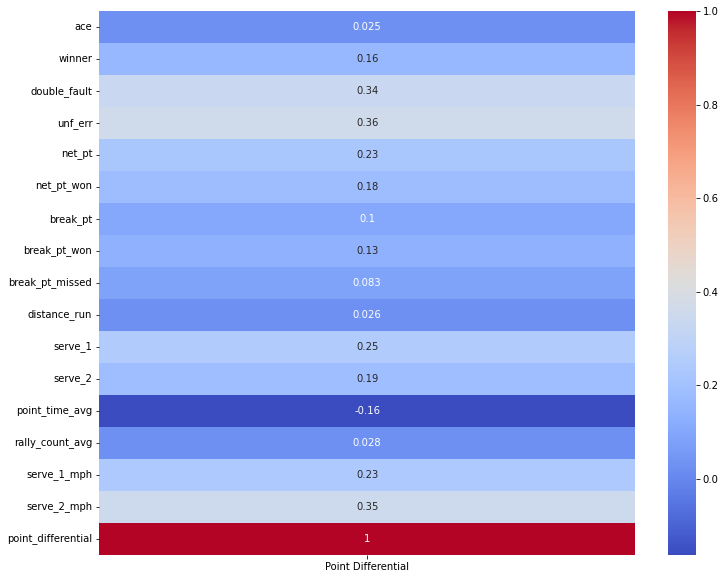

In [20]:
correlation_matrix_column1 = df_winners.corrwith(df_winners['point_differential'])

correlation_df = pd.DataFrame({'Point Differential': correlation_matrix_column1})

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_df, cmap="coolwarm", annot=True)

plt.show()

correlation_matrix_column1 = df_loser.corrwith(df_loser['point_differential'])

correlation_df = pd.DataFrame({'Point Differential': correlation_matrix_column1})

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_df, cmap="coolwarm", annot=True)

plt.show()

In [21]:
correlation_matrix_column1, p_values = [], []

for column in df_winners.columns:
    corr, p_value = pearsonr(df_winners[column], df_winners['point_differential'])
    correlation_matrix_column1.append(corr)
    p_values.append(p_value)

result_df = pd.DataFrame({'Correlation': correlation_matrix_column1, 'P-Value': p_values}, index=df_winners.columns)
print("Correlation and P-Value DataFrame:")
print(result_df)

correlation_matrix_column1, p_values = [], []

for column in df_loser.columns:
    corr, p_value = pearsonr(df_loser[column], df_loser['point_differential'])
    correlation_matrix_column1.append(corr)
    p_values.append(p_value)

result_df = pd.DataFrame({'Correlation': correlation_matrix_column1, 'P-Value': p_values}, index=df_loser.columns)
print("Correlation and P-Value DataFrame:")
print(result_df)

Correlation and P-Value DataFrame:
                    Correlation        P-Value
ace                    0.016030   9.317917e-01
winner                -0.030252   8.716579e-01
double_fault           0.328883   7.083690e-02
unf_err                0.062284   7.392419e-01
net_pt                -0.254948   1.663109e-01
net_pt_won            -0.289961   1.135809e-01
break_pt               0.344270   5.789701e-02
break_pt_won           0.197682   2.864323e-01
break_pt_missed        0.295095   1.070446e-01
distance_run           0.026301   8.883095e-01
serve_1                0.039700   8.320742e-01
serve_2                0.253216   1.693076e-01
point_time_avg        -0.162138   3.835175e-01
rally_count_avg        0.027553   8.830293e-01
serve_1_mph            0.258643   1.600433e-01
serve_2_mph            0.319216   8.004819e-02
point_differential     1.000000  1.550177e-228
Correlation and P-Value DataFrame:
                    Correlation        P-Value
ace                    0.025336   8.9